# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import preprocessing
import phik
from phik.report import plot_correlation_matrix
from phik import report

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
2136,c15981745N,Kia Rio X-line,economy,petrol,3.38,2014,73880,2019,48.72,engine_check
1173,j18260546M,Fiat 500,business,petrol,3.38,2013,44911,2021,30.51,engine_overheat
1367,k25002330L,MINI CooperSE,business,electro,4.44,2015,74028,2017,69.82,engine_check
1845,J-2212008m,VW Polo VI,economy,petrol,5.40,2014,63384,2014,23.15,wheel_shake
240,h-5894617f,Kia Sportage,standart,petrol,5.68,2013,40935,2017,52.67,engine_ignition


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
446376,Q16862684y,f11975477T,P1z,2020-02-05,1.23,180,1794,62,128.812807,0,2301.635975,0,18.588961,-0.001
111836,Z12447167E,I-1016418u,H1n,2020-03-08,2.69,25,268,83,128.857678,0,2116.405181,0,4.811050,-2.524
34521,p18673826H,C-2006279f,E1K,2020-02-06,4.09,85,1015,55,71.000000,2,898.160131,0,-9.122827,28.262
407510,f22378022p,d-1067020V,K1e,2020-01-02,4.77,43,596,41,130.000000,1,1793.408685,0,-0.061218,0.308
631501,a22384398N,s17437438h,E1w,2020-01-30,5.33,46,546,42,74.000000,1,1978.517116,0,-0.710577,32.107


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.head(16)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,19.0,l17437965W,1,2019-4-2
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19
2,59,7.8,947,4.0,g11098715c,0,2021-1-15
3,37,7.0,18,4.0,U12618125q,0,2019-11-20
4,39,8.2,428,7.0,A14375829B,0,2019-7-23
5,21,9.9,831,22.0,L95976611S,1,2020-9-18
6,39,6.9,2293,5.0,z74338505G,0,2022-3-30
7,26,7.9,142,5.0,q11106749z,1,2019-12-22
8,18,9.3,425,18.0,r77865210A,1,2020-6-4
9,23,9.2,601,12.0,t10928335r,1,2020-7-18


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(16)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
33430,I19994305a,XC,2020-2-22 12:40,reparking,1.0,33
54527,c21152319h,IP,2019-10-5 20:47,reparking,1.0,23
123737,e-9386234g,OX,2019-1-25 9:44,reparking,1.0,26
43916,n13675758u,ZB,2019-9-16 11:46,reparking,1.0,32
109860,O16337155M,KL,2019-4-16 4:22,refuel_check,1.0,26
74647,E22045798o,KC,2019-1-28 0:41,repair,5.4,26
83484,N-2592617I,LB,2020-9-21 8:59,reparking,1.0,25
22459,b-1404013d,EY,2020-6-29 16:46,reparking,1.0,31
56509,v36899226P,AS,2019-11-13 18:12,repair,6.5,24
29245,A10851146v,ZX,2018-2-26 22:12,reparking,1.0,27


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [6]:
# Пример расчета одного признака
# rides_info.groupby('car_id', as_index=False).agg(
#     mean_rating = ('rating', 'mean'),
#     # ... еще признаки
# )

# df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# YOUR CODE HERE

# Приведем столбец 'first_ride_date' таблицы 'driver_info' к типу дата и заполним пустые значения средним
driver_info['first_ride_date'] = pd.to_datetime(driver_info['first_ride_date'], format='%Y-%m-%d', errors='coerce')
driver_info['first_ride_date'].fillna(driver_info['first_ride_date'].mean(), inplace=True)

driver_info_upd = driver_info.copy()

# Новая фича - "стаж" водителя в каршеринговой компании на конец 2021 года
end_date = datetime.datetime(2021, 12, 31)
driver_exp = lambda x: (end_date - x).total_seconds()
driver_info_upd['driver_expirience'] = driver_info['first_ride_date'].apply(driver_exp)

rides_info = pd.merge(rides_info, driver_info_upd, how='left', on='user_id')

f = lambda x: x.nunique()
rides_df_gr = rides_info.groupby('car_id', as_index=False).agg(
                                                mean_rating = ('rating', 'mean'),
                                                distance_sum = ('distance', 'sum'),
                                                rating_min = ('rating', 'min'),
                                                speed_max = ('speed_max', 'max'),
                                                rides_count = ('ride_id', f),
                                                ride_time_median = ('ride_duration', 'median'),
                                                ride_stops_count = ('stop_times', 'sum'),
                                                user_quality_median = ('user_ride_quality', 'median'),
                                                rider_rating_mean = ('user_rating', 'mean'),
                                                car_accidents_sum = ('user_time_accident', 'sum'),
                                                driver_expirience = ('driver_expirience', 'mean'),
                                                driver_age_mean = ('age', 'mean')
                                                )

df = pd.merge(car_train, rides_df_gr, how='left', on='car_id')

df['driver_expirience'] = (df['driver_expirience'] - df['driver_expirience'].min()) / (df['driver_expirience'].max() - df['driver_expirience'].min())

/tmp/ipykernel_161539/536388881.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  driver_info['first_ride_date'].fillna(driver_info['first_ride_date'].mean(), inplace=True)


In [7]:
df.head(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,rating_min,speed_max,rides_count,ride_time_median,ride_stops_count,user_quality_median,rider_rating_mean,car_accidents_sum,driver_expirience,driver_age_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.1,180.855726,168,58.0,630,0.023174,8.229885,2056.0,0.681569,33.511494
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,0.0,187.862734,170,45.0,145,12.306011,7.988506,1212.0,0.737710,34.988506
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,0.1,102.382857,168,38.5,140,2.513319,7.843103,1701.0,0.757814,32.839080
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,0.1,172.793237,171,49.0,150,-5.029476,8.524138,2299.0,0.725331,34.977011
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,0.1,203.462289,172,41.5,132,-14.260456,8.112069,1891.0,0.522161,34.298851


In [8]:
f = lambda x: x.mode().iloc[0] # Нахождение самого частого значения в столбце

def rarest_value(series):
    """нахождение самого редкого значения в столбце

    Args:
        series (_type_): столбец

    Returns:
        _type_: самое редкое значение
    """
    return series.value_counts().idxmin()

fixes_df_gr = fix_info.groupby('car_id', as_index=False).agg(
                                                fix_duration_median = ('work_duration', 'median'),
                                                mean_destroy_degree = ('destroy_degree', 'mean'),
                                                rarest_work = ('work_type', rarest_value),
                                                most_freq_work = ('work_type', f)
                                                )

In [9]:
fixes_df_gr.head(5)

,car_id,fix_duration_median,mean_destroy_degree,rarest_work,most_freq_work
0,A-1049127W,28.0,2.714286,refuel,reparking
1,A-1079539w,25.5,4.329412,refuel,repair
2,A-1162143G,26.5,3.705882,refuel_check,repair
3,A-1228282M,24.5,2.908824,refuel,repair
4,A-1339912r,27.5,3.044118,refuel,repair


In [10]:
df = pd.merge(df, fixes_df_gr, how='left', on='car_id')

In [11]:
df.head(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,ride_stops_count,user_quality_median,rider_rating_mean,car_accidents_sum,driver_expirience,driver_age_mean,fix_duration_median,mean_destroy_degree,rarest_work,most_freq_work
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,630,0.023174,8.229885,2056.0,0.681569,33.511494,27.0,3.048571,refuel,reparking
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,145,12.306011,7.988506,1212.0,0.737710,34.988506,27.0,2.917143,refuel_reparking,reparking
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,140,2.513319,7.843103,1701.0,0.757814,32.839080,25.0,3.740000,refuel_reparking,repair
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,150,-5.029476,8.524138,2299.0,0.725331,34.977011,27.0,4.085714,refuel,repair
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,132,-14.260456,8.112069,1891.0,0.522161,34.298851,26.0,3.880000,refuel,repair


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_id               2337 non-null   object 
 1   model                2337 non-null   object 
 2   car_type             2337 non-null   object 
 3   fuel_type            2337 non-null   object 
 4   car_rating           2337 non-null   float64
 5   year_to_start        2337 non-null   int64  
 6   riders               2337 non-null   int64  
 7   year_to_work         2337 non-null   int64  
 8   target_reg           2337 non-null   float64
 9   target_class         2337 non-null   object 
 10  mean_rating          2337 non-null   float64
 11  distance_sum         2337 non-null   float64
 12  rating_min           2337 non-null   float64
 13  speed_max            2337 non-null   float64
 14  rides_count          2337 non-null   int64  
 15  ride_time_median     2337 non-null   f

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [13]:
# YOUR CODE HERE


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [14]:
# YOUR CODE HERE

cols2drop = ['car_id']
df.drop(cols2drop, axis=1, inplace=True, errors = 'ignore')

#### Введем рандомные признаки для оценки важности существующих фичей

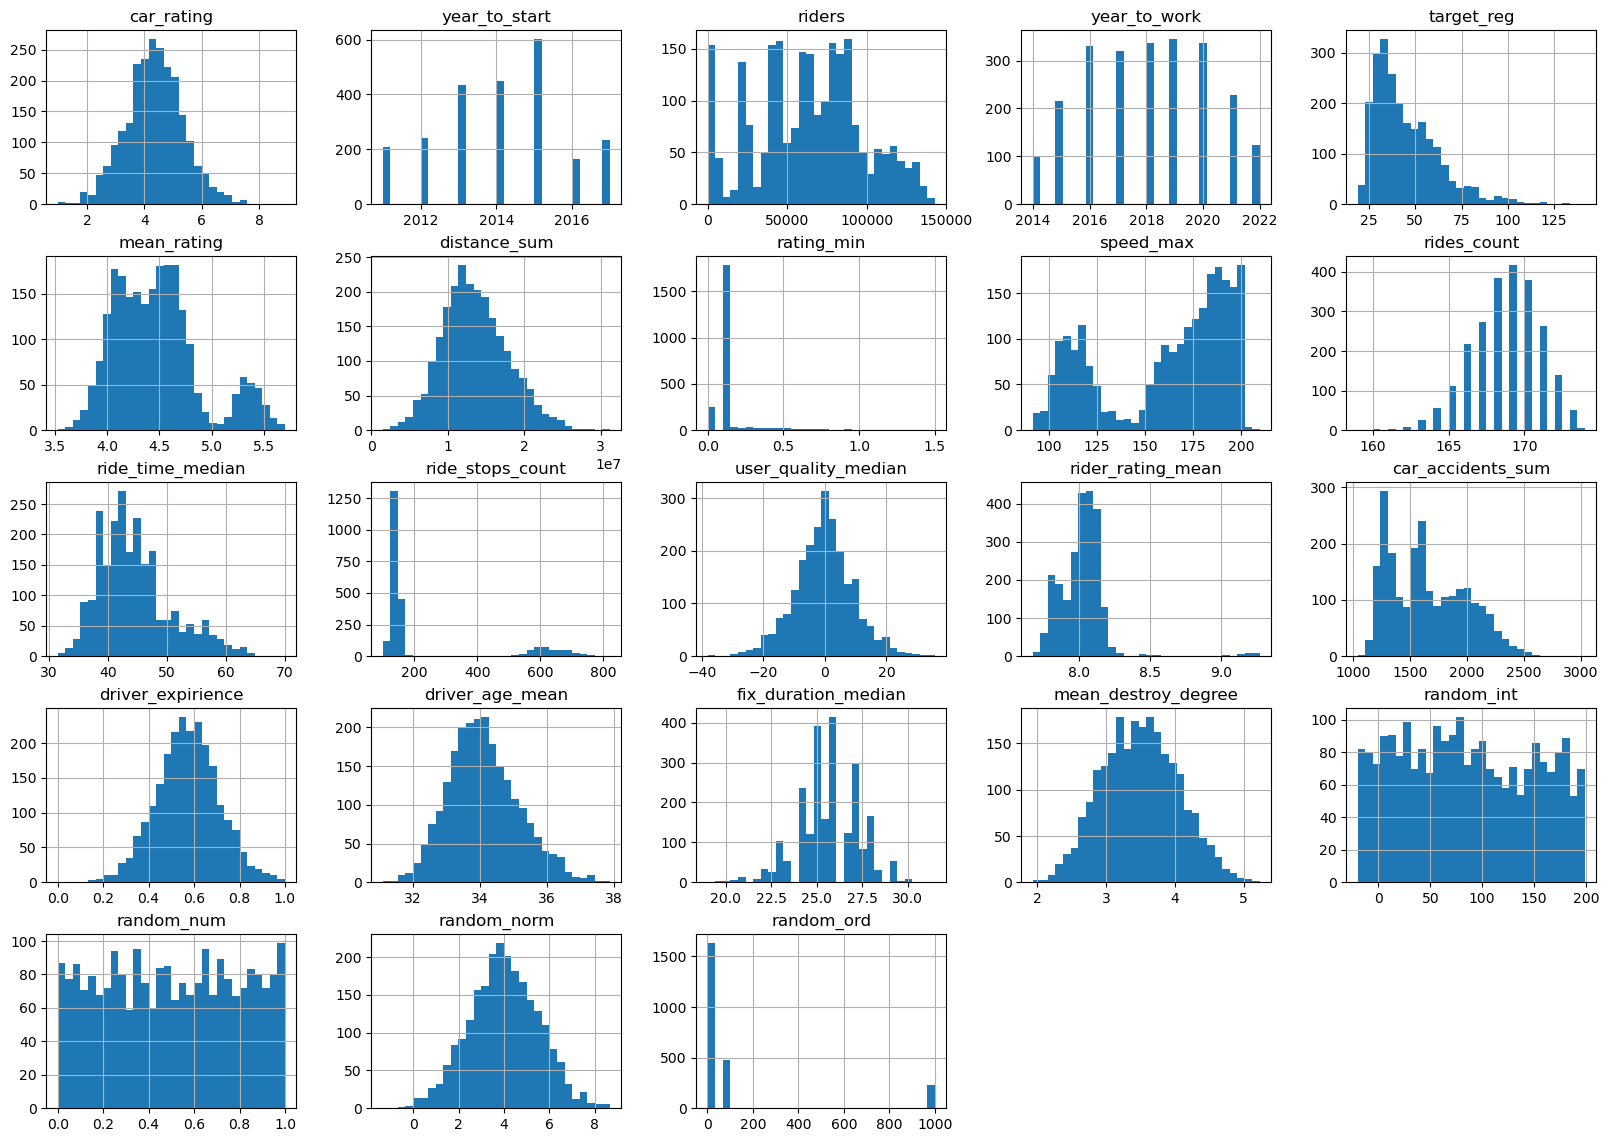

In [15]:
df['random_int'] = np.random.randint(-20, 200, df.shape[0]) # Целочисленный признак
df['random_num'] = np.random.random(size = df.shape[0]) # Признак типа float с равномерным распределением
df['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = df.shape[0]) # Признак с нормальным распределением
df['random_cat'] = np.random.choice(['A', 'B', 'C', 'D'], p = [0.20, 0.3, 0.45, 0.05], size = df.shape[0]) # Категориальный признак str формата с дисбалансом
df['random_ord'] = np.random.choice([1, 10, 100, 1000], p = [0.40, 0.3, 0.2, 0.1], size = df.shape[0]) # Численный категориальный признак

df.hist(figsize = (20, 14), layout = (-1, 5), bins=30);

#### Построим матрицу корреляции $\phi_k$

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'rides_count', 'ride_time_median', 'ride_stops_count', 'user_quality_median', 'rider_rating_mean', 'car_accidents_sum', 'driver_expirience', 'driver_age_mean', 'fix_duration_median', 'mean_destroy_degree', 'random_int', 'random_num', 'random_norm', 'random_ord']


/home/dwarf/miniconda3/envs/base_env/lib/python3.11/site-packages/phik/phik.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, inplace=True)


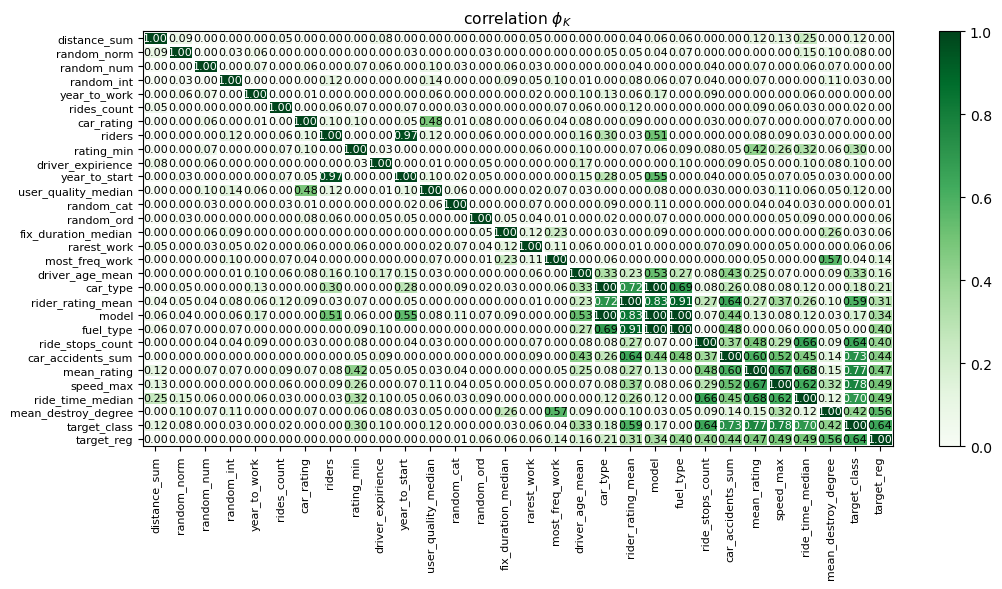

In [16]:
# Вычисляем матрицу корреляции phi_k
phik_overview = df.phik_matrix().round(2)

# Сортируем строки и столбцы по значениям корреляции в столбце 'target_reg'
sorted_columns = phik_overview['target_reg'].sort_values(ascending=False).index
phik_overview = phik_overview.loc[sorted_columns, sorted_columns]

# Строим матрицу корреляции
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(11, 6))

# Настраиваем компоновку и отображаем график
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'rides_count', 'ride_time_median', 'ride_stops_count', 'user_quality_median', 'rider_rating_mean', 'car_accidents_sum', 'driver_expirience', 'driver_age_mean', 'fix_duration_median', 'mean_destroy_degree', 'random_int', 'random_num', 'random_norm', 'random_ord']


/home/dwarf/miniconda3/envs/base_env/lib/python3.11/site-packages/phik/significance.py:328: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, inplace=True)


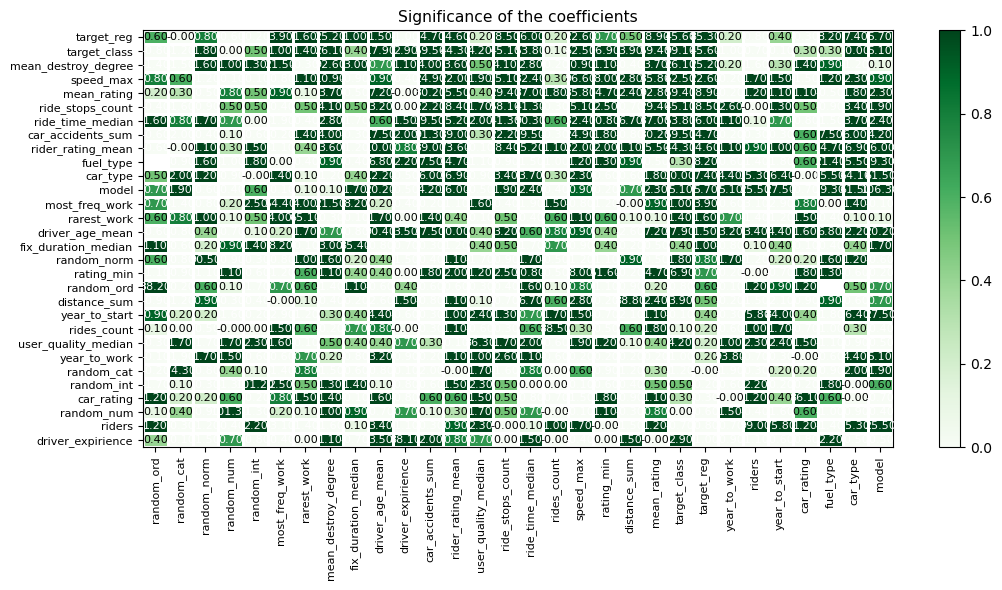

In [17]:
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()


#### Метод Feature Importance на примере CatBoost

In [18]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

drop_cols = ['car_id', 'target_class', 'target_reg']
cat_cols = ['car_type', 'fuel_type', 'model', 'rarest_work', 'most_freq_work', 'random_cat']

X = df.drop(drop_cols, axis=1, errors = 'ignore')
y = df['target_class'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.6644585	test: 1.6832923	best: 1.6832923 (0)	total: 250ms	remaining: 4m 10s
100:	learn: 0.0642993	test: 0.0856041	best: 0.0855115 (98)	total: 16.9s	remaining: 2m 30s
200:	learn: 0.0364824	test: 0.0692104	best: 0.0692018 (199)	total: 33.6s	remaining: 2m 13s
300:	learn: 0.0247802	test: 0.0630558	best: 0.0630558 (300)	total: 49.8s	remaining: 1m 55s
400:	learn: 0.0182277	test: 0.0597061	best: 0.0597061 (400)	total: 1m 6s	remaining: 1m 38s
500:	learn: 0.0143674	test: 0.0584428	best: 0.0583435 (490)	total: 1m 22s	remaining: 1m 22s
600:	learn: 0.0114177	test: 0.0580940	best: 0.0580566 (592)	total: 1m 38s	remaining: 1m 5s
700:	learn: 0.0095565	test: 0.0571271	best: 0.0571271 (700)	total: 1m 55s	remaining: 49.2s
800:	learn: 0.0082737	test: 0.0566691	best: 0.0566513 (790)	total: 2m 11s	remaining: 32.7s
900:	learn: 0.0072664	test: 0.0567103	best: 0.0565662 (806)	total: 2m 28s	remaining: 16.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest

In [19]:
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,24.829386
1,car_accidents_sum,16.903146
2,rider_rating_mean,14.647483
3,ride_stops_count,9.936275
4,rating_min,8.839689
5,mean_rating,8.567596
6,ride_time_median,6.712849
7,mean_destroy_degree,2.414698
8,model,1.259995
9,car_type,1.159821


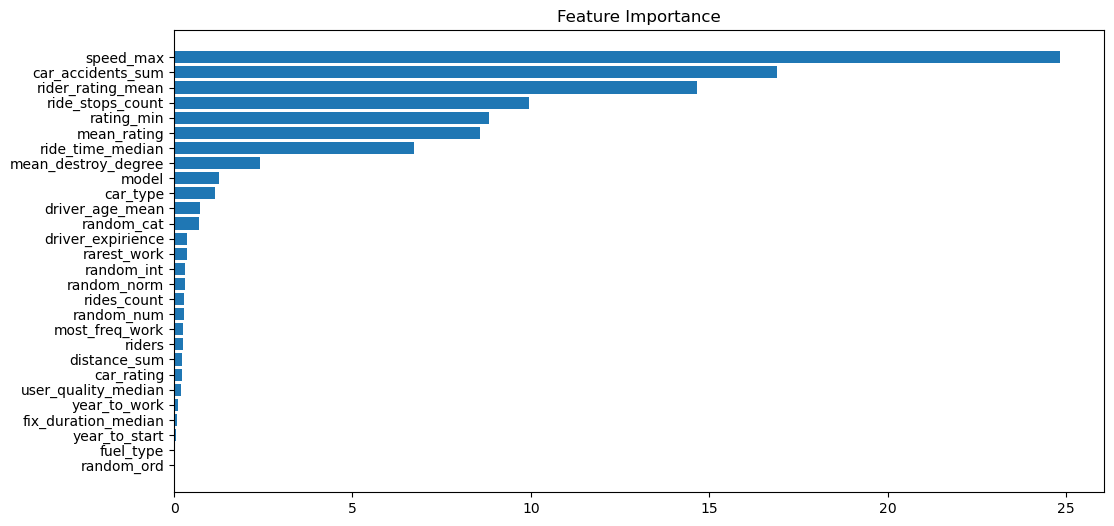

In [20]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

#### Метод Permutation Importance

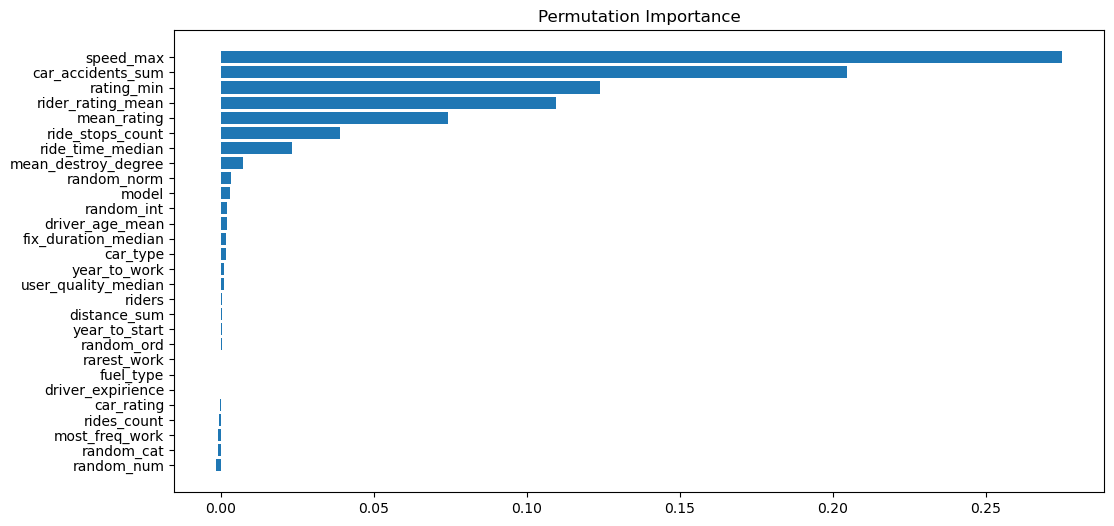

In [21]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

#### Рекурсивный метод CatBoost Feature Selection

In [22]:
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-27',
                      num_features_to_select=10,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

print(summary['selected_features_names'])

print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['model', 'car_type', 'mean_rating', 'rating_min', 'speed_max', 'ride_time_median', 'ride_stops_count', 'rider_rating_mean', 'car_accidents_sum', 'mean_destroy_degree']
Best loss: 0.05355583663792465


### Выводы: ###
- Введение рандомных признаков помогает в ранжировании важности фичей
- Для более четкого понимания важности фичей и их фильтрации необходимо использовать несколько разных методов, сравнивая и анализируя их результаты


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

### Необходимые импорты

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from shap import TreeExplainer, Explanation
from shap.plots import waterfall

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [24]:
pd.set_option('display.max_columns', 0) # Нвстройка отображения датасета

In [25]:
df_copy = df.copy() # Копия на всякий случай

In [26]:
df.sample(5)

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,rides_count,ride_time_median,ride_stops_count,user_quality_median,rider_rating_mean,car_accidents_sum,driver_expirience,driver_age_mean,fix_duration_median,mean_destroy_degree,rarest_work,most_freq_work,random_int,random_num,random_norm,random_cat,random_ord
504,Hyundai Solaris,economy,petrol,4.60,2015,86966,2016,79.28,another_bug,4.813103,9.619685e+06,0.40,189.000000,171,48.0,566,0.374115,8.124713,2133.0,0.581658,33.683908,27.0,4.122857,refuel,repair,50,0.489991,4.005866,B,10
1185,Kia Rio X-line,economy,petrol,6.66,2012,20822,2016,45.57,engine_fuel,4.079253,6.850545e+06,0.10,165.959756,168,44.0,138,2.556166,8.043678,1777.0,0.499657,34.488506,24.5,3.520588,refuel_check,reparking,30,0.048594,4.912984,B,10
104,Fiat 500,business,petrol,5.16,2015,80937,2022,54.71,engine_check,4.450115,1.383552e+07,0.10,159.698891,170,39.0,143,21.821151,8.149425,2240.0,0.539234,32.344828,25.0,2.982857,refuel,repair,61,0.261142,6.454383,C,1000
753,Kia Rio X,economy,petrol,4.06,2015,87280,2015,29.96,gear_stick,4.331897,1.444571e+07,0.10,108.350031,171,38.5,126,1.943446,7.788506,1527.0,0.638997,32.528736,25.0,3.191429,refuel_check,reparking,43,0.647950,6.235921,A,1
1893,Nissan Qashqai,standart,petrol,4.48,2012,23515,2020,36.41,break_bug,5.433161,6.319819e+06,0.18,104.930844,164,38.0,144,5.329655,8.069540,1383.0,0.494751,34.517241,26.5,4.000000,refuel_check,repair,94,0.208112,4.863736,C,10


### Классификация признаков на типы (категориальные, числовые, таргеты).

In [27]:
features2drop = ['random_int', 
                 'random_num', 
                 'random_norm', 
                 'random_cat', 
                 'random_ord'] # то, что надо выбросить

targets = ['target_reg', 
           'target_class'] # таргеты

cat_features = ['model', 
                'car_type', 
                'fuel_type', 
                'rarest_work', 
                'most_freq_work'] # категориальные признаки

num_features = ['car_rating', 
                'year_to_start', 
                'riders', 
                'year_to_work', 
                'mean_rating', 
                'distance_sum', 
                'rating_min', 
                'speed_max', 
                'rides_count', 
                'ride_time_median', 
                'ride_stops_count', 
                'user_quality_median', 
                'rider_rating_mean', 
                'car_accidents_sum', 
                'driver_expirience', 
                'driver_age_mean', 
                'fix_duration_median', 
                'mean_destroy_degree'] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 5 ['model', 'car_type', 'fuel_type', 'rarest_work', 'most_freq_work']
Числовые признаки: 18 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'rides_count', 'ride_time_median', 'ride_stops_count', 'user_quality_median', 'rider_rating_mean', 'car_accidents_sum', 'driver_expirience', 'driver_age_mean', 'fix_duration_median', 'mean_destroy_degree']
Целевые переменные ['target_reg', 'target_class']


### Отбросим ненужные колонки и сформируем наборы с признаками и таргетами

In [28]:
filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)]

X = df[filtered_features]
y = df["target_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Создание и обучение модели CatBoostClassifier.

In [29]:
clf = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.109335
0:	learn: 1.6883975	test: 1.6879070	best: 1.6879070 (0)	total: 123ms	remaining: 2m 3s
200:	learn: 0.0330974	test: 0.0703456	best: 0.0703284 (199)	total: 27.3s	remaining: 1m 48s
400:	learn: 0.0164887	test: 0.0614088	best: 0.0612007 (392)	total: 54.1s	remaining: 1m 20s
600:	learn: 0.0104249	test: 0.0585692	best: 0.0585692 (600)	total: 1m 20s	remaining: 53.5s
800:	learn: 0.0074629	test: 0.0572412	best: 0.0571249 (772)	total: 1m 47s	remaining: 26.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05712486101
bestIteration = 772

Shrink model to first 773 iterations.


### Оценка модели с использованием метрику accuracy

In [30]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9829


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

### Визуализация важности признаков встроенным в **CatBoost** методом **get_feature_importance**

In [31]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,speed_max,22.480112
1,car_accidents_sum,18.938013
2,rider_rating_mean,13.288701
3,mean_rating,10.712803
4,ride_time_median,9.081183
5,ride_stops_count,8.325814
6,rating_min,7.268894
7,mean_destroy_degree,2.627619
8,model,1.314268
9,car_type,1.314107


### График **shap.summary_plot** для оценки доли влияния фичей на классы

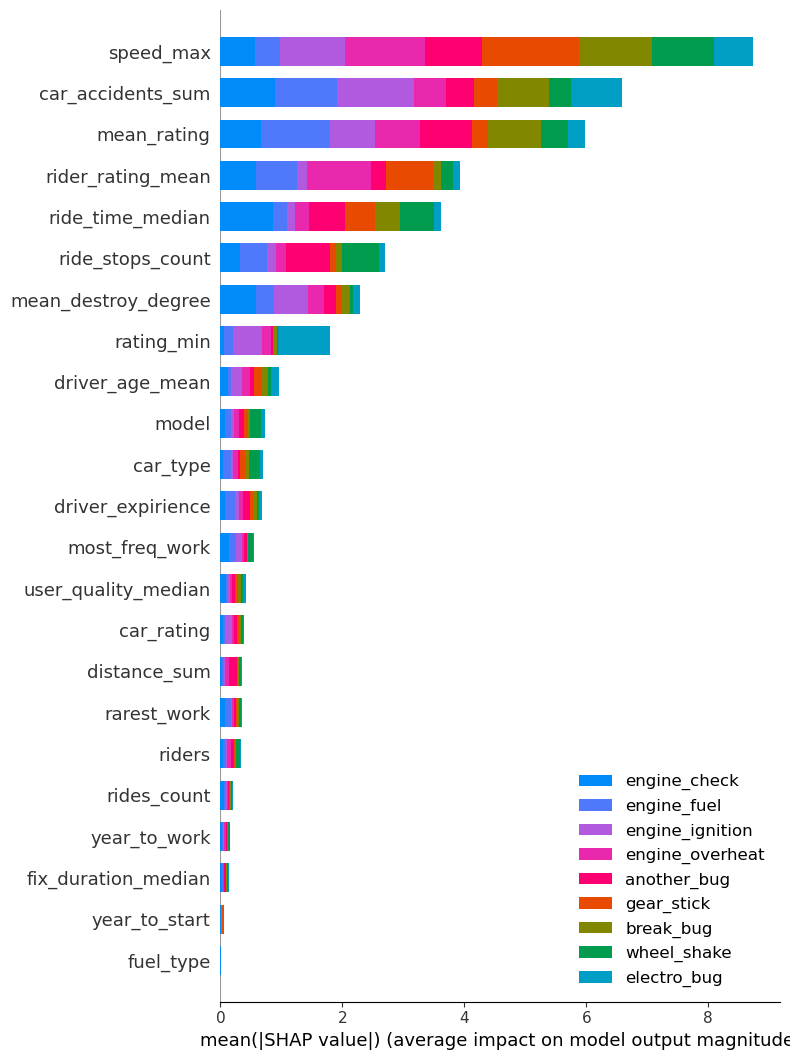

In [32]:
shap.initjs()

explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display=25, class_names=clf.classes_)


### График **shap.waterfall_plot** для наглядного объяснения доли вклада фичей в то, как модель решает, к какому классу отнести запись в наборе данных

#### Выведем имена target-классов

In [108]:
_ = pd.DataFrame(clf.classes_, columns=['target_class'])
display(_)

,target_class
0,another_bug
1,break_bug
2,electro_bug
3,engine_check
4,engine_fuel
5,engine_ignition
6,engine_overheat
7,gear_stick
8,wheel_shake


#### Возьмем запись из тестового набора и посмотрим, к какому классу ее отнесла модель

In [97]:
X_test.iloc[1]

model                       VW Polo VI
car_type                       economy
fuel_type                       petrol
car_rating                         5.0
year_to_start                     2015
riders                           87354
year_to_work                      2018
mean_rating                   4.049598
distance_sum           17976546.948301
rating_min                         0.0
speed_max                        200.0
rides_count                        167
ride_time_median                  44.0
ride_stops_count                   149
user_quality_median           2.871492
rider_rating_mean             7.975862
car_accidents_sum               1293.0
driver_expirience             0.532913
driver_age_mean              34.091954
fix_duration_median               27.5
mean_destroy_degree           5.002941
rarest_work                     refuel
most_freq_work                  repair
Name: 2025, dtype: object

In [98]:
y_test.iloc[1]

'electro_bug'

#### Посмотрим, какие фичи какой вклад внесли в решение модели отнести запись к таргет-классу

electro_bug


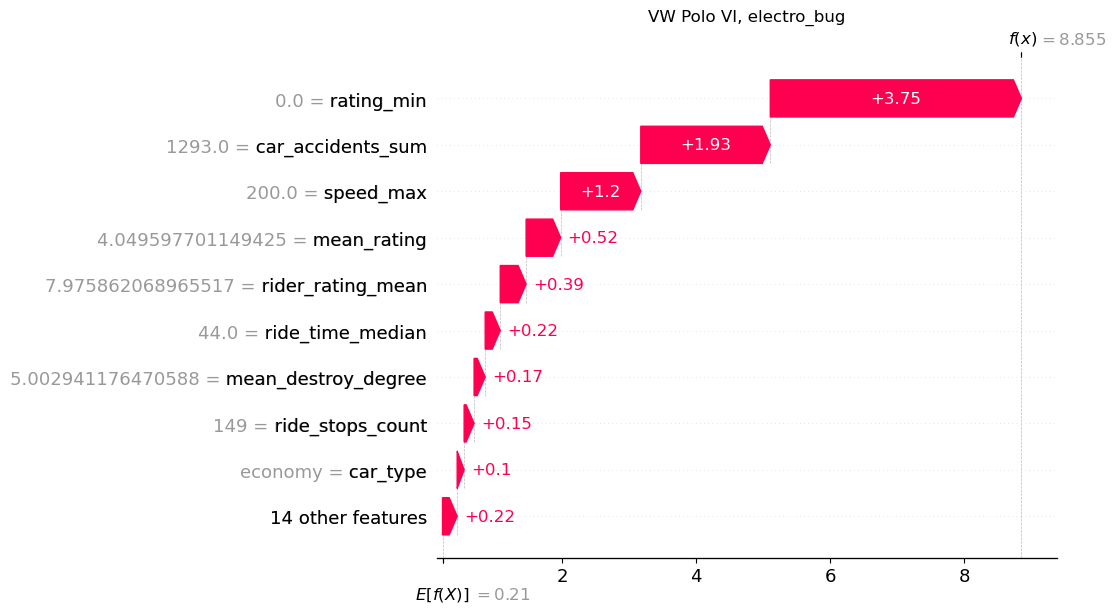

In [100]:
explainer = shap.Explainer(clf)
s_values = explainer(X_test)

target_class = 2
target_class_name = clf.classes_[target_class]

shap_waterfall = shap.waterfall_plot(s_values[1][:, target_class], show=False)

fig = plt.figure(shap_waterfall)
plt.title(f'{s_values.data[1][0]}, {target_class_name}')

print(target_class_name)

plt.show()

### Построим **classification_report** из библиотеки **scikit-learn**

#### Хорошо видна сбалансированность классов и высокие значения метрик

In [109]:
report = classification_report(y_test, y_pred, target_names=clf.classes_)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      0.94      0.97        49
    engine_fuel       0.92      1.00      0.96        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      0.96      0.98        48
     gear_stick       1.00      1.00      1.00        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.98       468
      macro avg       0.98      0.98      0.98       468
   weighted avg       0.98      0.98      0.98       468



In [110]:
rep = pd.DataFrame(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_,
                            output_dict=True)).T

rep['support'] = rep['support'].apply(int)
rep.style.background_gradient(cmap='cividis', subset=pd.IndexSlice['another_bug':'wheel_shake', :'f1-score'])

,precision,recall,f1-score,support
another_bug,0.966102,0.982759,0.974359,58
break_bug,1.000000,1.000000,1.000000,56
electro_bug,1.000000,1.000000,1.000000,51
engine_check,1.000000,0.938776,0.968421,49
engine_fuel,0.920635,1.000000,0.958678,58
engine_ignition,1.000000,1.000000,1.000000,58
engine_overheat,1.000000,0.958333,0.978723,48
gear_stick,1.000000,1.000000,1.000000,51
wheel_shake,0.973684,0.948718,0.961039,39
accuracy,0.982906,0.982906,0.982906,0


### Пострим матрицу смежности. В целом неплохо, но модель путает классы 4-6 4-3 0-8. Хуже всего предсказан класс 4 - 'engine_fuel', это заметно и по **classification_report** выше.

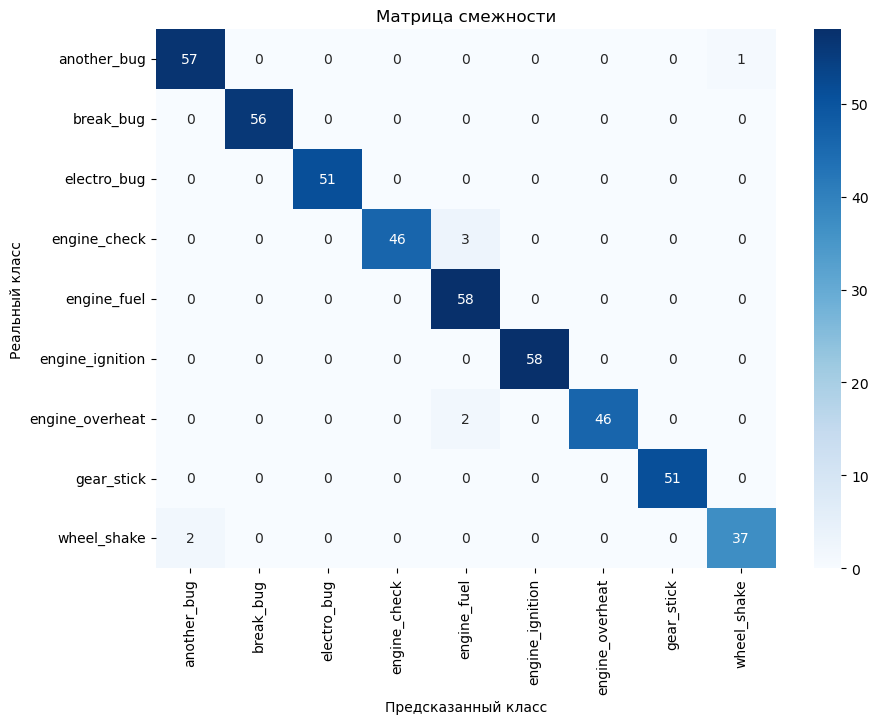

In [111]:
cm = confusion_matrix(y_test, y_pred)
class_mapping = clf.classes_

# Визуализация матрицы смежности
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping, yticklabels=class_mapping)
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
plt.title('Матрица смежности')
plt.show()

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.